<h1 style="text-align: center;">New York City Taxi Trip Duration</h1>

Не буду особо марафетить сие поле, описание можно посмотреть <a href='https://www.kaggle.com/competitions/nyc-taxi-trip-duration/overview'>тут</a>.

**Бизнес-задача:** спрогнозировать длительность поездки такси.

На вход получаем таблицу с следующими признаками:

**Данные о клиенте и таксопарке:**
* `id` - уникальный идентификатор поездки
* `vendor_id` - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* `pickup_datetime` - дата и время, когда был включен счетчик поездки
* `dropoff_datetime` - дата и время, когда счетчик был отключен

**Географическая информация:**
* `pickup_longitude` -  долгота, на которой был включен счетчик
* `pickup_latitude` - широта, на которой был включен счетчик
* `dropoff_longitude` - долгота, на которой счетчик был отключен
* `dropoff_latitude` - широта, на которой счетчик был отключен

**Прочие признаки:**
* `passenger_count` - количество пассажиров в транспортном средстве (введенное водителем значение)
* `store_and_fwd_flag` - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* `trip_duration` - продолжительность поездки в секундах

<h2 id='contents'>Оглавляшка:</h2>

* [Блок функций](#funcblock)

<center><span style="font-size:30px;">Преобразование тренировочной части данных</span></center>

<span style="font-size:25px;"><a href='#thebeginning'>Первичная обработка данных:</a></span> <- Здесь подгрузка начальной таблицы 

P.S. но сначала небходимо запустить ячейку с библиотеками и блок функций (да, нужно полистать немного) ^^

* [Преобразование признака pickup_datetime](#pickupdatetimepreparation)
* [Добавление данных из таблицы holidays](#holidaysdf)
* [Добавление данных из OSRM](#osrmdf)
* [Добавление признаков дистанции и угла направления](#haversineazimuth)
* [Добавление признака кластеризации широты и долготы](#geoclustering)
* [Добавление признаков, отвечающих за погоду](#weatherdf)
* [Заполнение пропущеных значений](#nanvalsinweather)
* [Частичное удаление выбросов](#firstlogicaloutliers)

<span style="font-size:25px;">Разведывательный анализ данных (EDA):</span>

* [Логарифмирование таргета и проверка на нормальность](#normaltestoftargft)
* [Зависимость таргета от `vendor_id`](#vendorvstarget)
* [Зависимость таргета от `store_and_fwd_flag`](#safflvstripdur)
* [Зависимости количества поздок и их медианной длительности от часа дня](#dependenciesbytime)
* [Зависимости количества поздок и их медианной длительности от дня недели](#dependenciesbydayofweek)
* [Тепловая карта зависимости таргета от признаков часа дня и дня недели](#pickuphourvspickupdayofweek)
* [Диаграмма рассеяния по точкам координат](#scatteroflatlong)

<span style="font-size:25px;">Отбор и преобразование признаков:</span>

* [Удаление пары неинформативных признаков](#dataleakandnoninform)
* [Кодирование признаков `vendor_id` и `store_and_fwd_flag`](#vendorflagencoding)
* [Кодирование признаков `pickup_day_of_week`, `geo_cluster` и `events`](#pickupdayofweekgeoclustereventsenco)
* [Здесь покоятся X, y и делилка](#xyhere)
* [Отбор признаков с помощью `SelectKBest`](#selectkbestselection)
* [Нормализация `MinMax` шкалёром](#normalizationofx) Здесь находится финальные Х и у третьего блока

<span style="font-size:25px;">Решение задачи регрессии: линейная регрессия и деревья решений:</span>

* [Базовая модель линейной регрессии](#basiclinreg)
* [Линейная модель, обученная на полиномиальных признаках второй степени](#linregpoly)
* [Модель L2 регулярицации `Ridge`](#ltworegul)
* [Обучение дерева решений `DecisionTreeRegressor`](#treeregressorbasic)
* [Обучение дерева решений с подбором параметра `max_depth`](#treeregressorvsmaxdepth)

<span style="font-size:25px;">Решение задачи регрессии: ансамбли моделей и построение прогноза:</span>

* [`RandomForest`](#randomforest)
* [`GradientBoosting`](#gradientboosting)
* [Сравнение метрик моделей](#modelscomparison)
* [Диаграмма значимости признаков](#feauturesimportances)
* [Метрика MeAE](#meaeforgradientboosting)

<center><span style="font-size:30px;">Финальный шаг. Предсказание на неразмеченных данных:</span></center>

* [Преобразование тестовой таблицы](#testdatapreparation)
* [Предсказание и запись в `submission`](#predictionvssubmission)

<center><span style="font-size:30px;">Дополнительная часть:</span></center>

* [Использование модели `XGBoost`](#xgboosttest)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from scipy import stats

from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_log_error, root_mean_squared_error

pd.set_option('display.float_format', None)
#pd.set_option('display.float_format', '{:.4f}'.format)
#np.set_printoptions(suppress=True, precision=4)
np.set_printoptions(suppress=False, precision=8)

plt.style.use('seaborn-v0_8') #стиль отрисовки seaborn
%matplotlib inline
# Python 3.12.7

## Блок функций <a id='funcblock'></a>

In [ ]:
# My info.
def my_info(df, catmaxnum=None):
    """Info function to show basic df indicators

    Args:
        df (pd.Dataframe): any df.
        catmaxnum (int): the minimum threshold(rus: порог) after which a column will be considered a category. Defaults to None.

    Returns:
        _type_: HTML object
    """
    import pandas as pd
    import numpy as np
    from IPython.display import HTML
    
    df_copy = df.copy() # it needs here.
    
    # Loop and condition for moment, when there are unhashable types in our column. (list, dict, set)
    for i in df_copy.columns:
        if any(isinstance(cell, (list, set, dict)) for cell in df_copy[i]):
            df_copy[i] = df_copy[i].astype(str)
                
    func_df = pd.DataFrame({
        
        'column': df_copy.columns,
        'num of unique vals': df_copy.nunique(),
        'type': [str(df_copy.dtypes[i]) for i in df_copy.columns],
        'mode': [round(df_copy[i].mode()[0], 2) if pd.api.types.is_numeric_dtype(df_copy[i].dtype) else df_copy[i].mode()[0] for i in df_copy.columns],
        'number of entries': len(df_copy),
        'NaN vals': df_copy.isna().sum(),
        'number of dublics': df_copy.duplicated().sum(),
        'describe': [f"{df_copy[i].describe().reindex(['min', 'max', 'mean', 'std']).round(2).to_string()}" if pd.api.types.is_numeric_dtype(df_copy[i].dtype) else 'see type column' for i in df_copy.columns]
        
    }).sort_values(by=['num of unique vals', 'column'], ascending=[True, True]).reset_index(drop=True)
    
    if catmaxnum:
        func_df.insert(3, 'classification', ['category' if i < catmaxnum else 'numeric' for i in func_df['num of unique vals']])
    
    if len(str(df_copy.memory_usage(deep=True).sum())) > 6:
        print(f"memory usage: {str(round(df_copy.memory_usage(deep=True).sum() / 1e6, 1)) + ' MB'}")
    else:
        print(f"memory usage: {str(round(df_copy.memory_usage(deep=True).sum() / 1e3, 1)) + ' KB'}")
    
    # Add CSS style to left-align the "describe" column
    html_output = func_df.to_html().replace('\\n', '<br>')
    html_output = html_output.replace('<td>min', '<td style="text-align: left;">min...:')
    html_output = html_output.replace('<br>max', '<br style="text-align: left;">max..:')
    html_output = html_output.replace('<br>mean', '<br style="text-align: left;">mean:')
    html_output = html_output.replace('<br>std', '<br style="text-align: left;">std....:')
    
    return HTML(html_output)

#########################################

def hist_box_qq(arg, full_iqr=False):
    """Function of drawing histogram, box and cuckoo in one bottle.

    full_iqr... It's shorter.. I wrote a function for the lognormal distribution, i.e. there are no outliers on the left.
    But then I thought about it and decided to add it, because then I still log the feature.
    And in general, if the array is usually distributed.
    In a word: full_iqr is Boolean. By default, False. I.e., only the right borders are drawn.
    
    The input is a Series or array.

    Args:
        arg (Series/np.array): any numeric series or array.
        full_iqr (bool, optional): choose, u wanna show only right outliers borders or both. Defaults to False.

    Returns:
        plt
    """
    
    import pandas as pd
    import matplotlib.pyplot as plt
    import statsmodels.api as sm # рисовалка qq-plot.
    import seaborn as sns
    
    func_arg = arg.copy()
    # replace inf.
    func_arg = func_arg.replace([np.inf, -np.inf], np.nan)
    # If there is a nan, I drop it. Because it does not draw if there is a nan.
    func_arg = pd.Series(func_arg).dropna()
    
    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=[18, 5])
    
    # The histogram. And the settings for the histogram lines. Legend = label in each line.
    # Red is the median, green is the tukey, and blue is 3 sigma.
    sns.histplot(func_arg, kde=True, bins=50, ax=ax[0])
    
    ax[0].get_lines()[0].set_color('black')
    ax[0].axvline(func_arg.median(), color='red', linestyle='--', linewidth='1.8', label='median')
    ax[0].axvline(func_arg.quantile(0.75) + ((func_arg.quantile(0.75) - func_arg.quantile(0.25)) * 1.5), color='g', ls='--', lw=2, label='1.5 IQR Tukie')
    ax[0].axvline(func_arg.mean() + 3 * func_arg.std(), color='b', ls='--', lw=2, label='3 IQR z-score')
    ax[0].legend()
    ax[0].set_xlabel(f'Feauture {func_arg.name}')
    
    # Box. And the settings for it.
    sns.boxplot(func_arg, ax=ax[1], orient='h', medianprops={'color': 'red', 'linestyle': '--'})

    ax[1].axvline(func_arg.quantile(0.75) + ((func_arg.quantile(0.75) - func_arg.quantile(0.25)) * 1.5), color='g', ls='--', lw=2, label='1.5 IQR Tukie')
    ax[1].axvline(func_arg.mean() + 3 * func_arg.std(), color='b', ls='--', lw=2, label='3 IQR z-score')
    ax[1].legend()    
    ax[1].set_xlabel(f'Feauture {func_arg.name}')
    
    if full_iqr: # Left emission catch lines are added.
        ax[0].axvline(func_arg.quantile(0.25) - ((func_arg.quantile(0.75) - func_arg.quantile(0.25)) * 1.5), color='g', ls='--', lw=2)
        ax[0].axvline(func_arg.mean() - 3 * func_arg.std(), color='b', ls='--', lw=2)
        ax[1].axvline(func_arg.quantile(0.25) - ((func_arg.quantile(0.75) - func_arg.quantile(0.25)) * 1.5), color='g', ls='--', lw=2)
        ax[1].axvline(func_arg.mean() - 3 * func_arg.std(), color='b', ls='--', lw=2)
    
    # This line builds a Q-Q graph.
    qq = sm.ProbPlot(func_arg, fit=True).qqplot(marker='*', markerfacecolor='b', markeredgecolor='b', alpha=0.3, ax=ax[2])
    # Line, also with the ability to influence color. fmt parameter.
    sm.qqline(qq.axes[2], line='45', fmt='r', linestyle='--')
    
    # The general title.
    plt.suptitle(f'Distribution of the feature: {func_arg.name}').set_fontsize(20)
    
    return plt

#########################################

def print_metrics(y_test, y_test_pred, list_of_metrics, y_train=None, y_train_pred=None, names=False, metric_params_dict=False):
    """print_metrics 

    function for print any metric u like.
    P.S. some metrics have hard names, so need to adjust names in 'block to adjust names' (see code)

    Args:
        y_test (pd.Series or numpy.ndarray): y_test
        y_test_pred (list): y_test_pred (lgr.predict(X_test))
        list_of_metrics (list): list of any metrics !!CAUTION!! Metrics should be imported like: from sklearn.metrics import accuracy_score
        y_train (pd.Series or numpy.ndarray, optional): y_train. Defaults to None.
        y_train_pred (list, optional): y_train_pred. Defaults to None.
        names (list, optional): list of algo names (for ex: ['lgr_1', 'lgr_2']). Defaults to False.
        metric_params_dict (dict, optional): dict look like {'metric_name': {'parameter': 'value'}}. Defaults to False.

    Returns:
        pd.DataFrame: with our metrics
        
    ex of using:
    
    list_of_metrics = ['accuracy_score', 'f1_score', 'precision_score', 'recall_score']
    metric_params_dict = {'accuracy_score': {'normalize': False}}
    
    print_metrics(y_test=y_test, 
                  y_test_pred=[y_test_pred], 
                  list_of_metrics=list_of_metrics,
                  names=['lgr_1'], metric_params_dict=metric_params_dict)
    """
    
    import pandas as pd
    
    # if we didnt set names it will be 0, 1 etc.
    if not names:
        names = [f'{i}' for i in range(len(y_test_pred))]
    
    ################### <----- block to adjust metrics params
    # if we dont want to specify additional metric params
    if not metric_params_dict:
        metric_params_dict_func = {i:{} for i in list_of_metrics}
    # else we make empty dict with each metric and update it with needed external dict
    else:
        metric_params_dict_func = {i:{} for i in list_of_metrics}
        metric_params_dict_func.update(metric_params_dict)
    
    ################### <----- block to adjust names 
    # This for correct metrics names.
    func_list_of_metrics = []
    
    for i in list_of_metrics:
        # For ex: mean_absolute_error = MAE (if len(['mean', 'absolute', 'error']) > 2)
        if len(i.split('_')) > 2:
            func_list_of_metrics.append(''.join([j[0].capitalize() for j in i.split('_')]))
        # else r2_score = r2
        else:
            func_list_of_metrics.append(i.split('_')[0])
    ###################
    
    train_dict = {}
    test_dict = {}
    train_list = [[] for i in range(len(list_of_metrics))]
    test_list = [[] for i in range(len(list_of_metrics))]
    
    ###################
    # if we wanna see just test metrics:
    if y_train is None:
        for y_test_p in y_test_pred:
            for i, j in enumerate(list_of_metrics):
                # values of metrics
                test_value = globals()[j](y_test, y_test_p, **metric_params_dict_func[j])
                # adding to list
                test_list[i].append(test_value)
                
                # refresh dict
                test_dict[f"{func_list_of_metrics[i]}"] = test_list[i]
        
        func_df = pd.DataFrame(test_dict, index=names).T

    
    # if we wanna see train and test scores:    
    else:
        # for train_pred + test_pred
        for y_train_p, y_test_p in zip(y_train_pred, y_test_pred):
            for i, j in enumerate(list_of_metrics):
                # values of metrics
                train_value = globals()[j](y_train, y_train_p, **metric_params_dict_func[j])
                test_value = globals()[j](y_test, y_test_p, **metric_params_dict_func[j])
                # adding to lists
                train_list[i].append(train_value)
                test_list[i].append(test_value)
                
                # refresh dicts
                train_dict[f"{func_list_of_metrics[i]}"] = train_list[i]
                test_dict[f"{func_list_of_metrics[i]}"] = test_list[i]
        
        # making MultiIndex for columns
        columns = pd.MultiIndex.from_product([['train', 'test'], names])
        
        # Combining the data into one array for further creation of a df
        data = [train_list[i] + test_list[i] for i, metric in enumerate(func_list_of_metrics)]
        
        # Creating a df with a multi-index
        func_df = pd.DataFrame(data, index=func_list_of_metrics, columns=columns)
    
    return func_df

#########################################

def add_datetime_features(df, col, dayofweek=False):
    
    func_df = df.copy()
    func_df[col] = pd.to_datetime(func_df[col], errors='coerce')
    
    func_df[col+'_date'] = func_df[col].dt.date.astype('datetime64[ns]')
    func_df[col+'_hour'] = func_df[col].dt.hour
    
    if dayofweek:
        func_df[col+'_day_of_week'] = df[col].dt.day_name()
    
    return func_df

#########################################

def add_holiday_features(df1, df2, on):
    
    func_df = df1.merge(df2, how='left', on=on)
    func_df.iloc[:, -1] = func_df.iloc[:, -1].apply(lambda x: 1 if pd.notna(x) else 0)
    
    return func_df

#########################################

def add_osrm_features(df1, df2, on):
    return df1.merge(df2, how='left', on=on)

#########################################

def lat_long_dist(matrix, rad=6.371*1e+6, azimut=False):
    """function to calculate distance between 2 points lat and long
       https://gis-lab.info/qa/great-circles.html

    Args:
        matrix (list, array, or df): any data sequence u like
        rad (float or int, optional): radius of the earth. Defaults to 6.371*1e+6 in meters!!!.
        azimut (bool, optional): the angle in decimal degrees. Defaults to False.

    Returns:
        array: the array can be shape of (m,) or (m, n) depending on what we have submitted to the input
    """
    
    import numpy as np
    import pandas as pd
    
    if isinstance(matrix, list):
        matrix = np.array(matrix)
    elif isinstance(matrix, pd.DataFrame):
        matrix = matrix.to_numpy()
    
    # the order of sequence can be changed here
    # the order of start-end will only affect the azimuth
    # cuz for the distance there is no matter what lat or long, its the distance between 2 points
    if len(matrix.shape) == 2:
        lat_start, long_start, lat_end, long_end = matrix[:, 0], matrix[:, 1], matrix[:, 2], matrix[:, 3]
    else:
        lat_start, long_start, lat_end, long_end = matrix[0], matrix[1], matrix[2], matrix[3]
    
    # radians of lat
    f1 = lat_start * (np.pi / 180)
    f2 = lat_end * (np.pi / 180)
    
    # delta radians
    delta_lat = (lat_end - lat_start) * (np.pi / 180)
    delta_long = (long_end - long_start) * (np.pi / 180)
    
    # Haversine formula 
    a = np.power(np.sin(delta_lat / 2), 2) + np.cos(f1) * np.cos(f2) * np.power(np.sin(delta_long / 2), 2)
    haversine = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    dist = rad * haversine
    
    if not azimut:
        return dist
    else:
        # teta formula for azimut
        teta = np.arctan2(np.sin(delta_long) * np.cos(f2), np.cos(f1) * np.sin(f2) - np.sin(f1) * np.cos(f2) * np.cos(delta_long))
        
        return np.array([dist, (teta * (180 / np.pi) + 360) % 360]).T # % 360 == module 360

#########################################

def fill_null_weather_data(df):
    
    func_df = df.copy()
    
    func_df.loc[:, ['total_distance', 'total_travel_time', 'number_of_steps']] = func_df.loc[:, ['total_distance', 'total_travel_time', 'number_of_steps']].fillna(func_df.loc[:, ['total_distance', 'total_travel_time', 'number_of_steps']].median())
    func_df['events'] = func_df['events'].fillna('None')
    
    func_df.loc[:, ['pickup_datetime_date', 'temperature', 'visibility', 'wind speed', 'precip']] = func_df.loc[:, ['pickup_datetime_date', 'temperature', 'visibility', 'wind speed', 'precip']].fillna(func_df.loc[:, ['pickup_datetime_date', 'temperature', 'visibility', 'wind speed', 'precip']].groupby('pickup_datetime_date').transform('median'))
    
    return func_df

#############################################

def func_for_2_4(df, col):
    # в курсе в качестве ответа принимался диапазон, потому функция чисто для этого
    func_df = df.copy()
    
    lambda_for_index = lambda x: 'с 00.00 по 5.00' if x >= 0 and x <= 5 else\
        'с 6.00 по 12.00' if x >= 6 and x <= 12 else\
            'с 13.00 по 18.00' if x >= 13 and x <= 18 else\
                'с 18.00 по 23.00'
    func_df[col] = func_df[col].apply(lambda_for_index)
    return func_df

#############################################

def swarm_hist(df, targ_col, depend_col, figsize=(15, 5)):
    
    # сырая, есть что добавить в гиперпараметры
    
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    fig, ax = plt.subplots(ncols=2, figsize=figsize)
    
    # Построение графиков beeswarm + hist
    for i, j in enumerate(df[depend_col].unique()[::-1]):
        y = df[df[depend_col] == j]
        x = np.random.normal(i + 1, 0.1, size=len(y)) # 0.1 отвечает за расстояние между
        ax[0].plot(x, y[targ_col], '*', label=f'{depend_col} {j}', alpha=0.6)
        
        # +i * 12 - чтобы башенки гистограмм не накладывались друг на друга (12 - отвечает за расстояние между)
        sns.histplot(y[targ_col] + i * 12, ax=ax[1], kde=False, 
                     label=f'{depend_col} {j}', binwidth=0.2, color=f"C{i}", alpha=0.5)
    
    ax[0].set_xticks(df[depend_col].unique()[::-1])
    ax[0].set_xlabel(f'{depend_col.capitalize()}')
    ax[0].set_ylabel(f'{targ_col.capitalize()}')
    ax[0].set_title(f'Beeswarm plot of {targ_col.capitalize()} by {depend_col.capitalize()}')
    ax[0].legend()
    
    ax[1].set_title(f'Histogram of {targ_col.capitalize()} by {depend_col.capitalize()}')
    ax[1].set_xticks([])
    ax[1].set_xlabel(f'{targ_col.capitalize()}')
    ax[1].set_ylabel('Count')
    ax[1].legend()
    
    return plt

## Основное

<h2 id='thebeginning' style='text-align:center;'>Первичная обработка данных</h2>

In [ ]:
# у меня 10 сек
stage_1_df = pd.read_csv('data/train.csv')
my_info(stage_1_df)

memory usage: 437.6 MB


,column,num of unique vals,type,mode,number of entries,NaN vals,number of dublics,describe
0,store_and_fwd_flag,2,object,N,1458644,0,0,see type column
1,vendor_id,2,int64,2,1458644,0,0,min...: 1.00max..: 2.00mean: 1.53std....: 0.50
2,passenger_count,10,int64,1,1458644,0,0,min...: 0.00max..: 9.00mean: 1.66std....: 1.31
3,trip_duration,7417,int64,368,1458644,0,0,min...: 1.00max..: 3526282.00mean: 959.49std....: 5237.43
4,pickup_longitude,23047,float64,-73.98,1458644,0,0,min...: -121.93max..: -61.34mean: -73.97std....: 0.07
5,dropoff_longitude,33821,float64,-73.98,1458644,0,0,min...: -121.93max..: -61.34mean: -73.97std....: 0.07
6,pickup_latitude,45245,float64,40.77,1458644,0,0,min...: 34.36max..: 51.88mean: 40.75std....: 0.03
7,dropoff_latitude,62519,float64,40.77,1458644,0,0,min...: 32.18max..: 43.92mean: 40.75std....: 0.04
8,pickup_datetime,1380222,object,2016-01-12 18:48:44,1458644,0,0,see type column
9,dropoff_datetime,1380377,object,2016-02-19 19:25:04,1458644,0,0,see type column


<h3>1.1</h3>

Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведите признак `pickup_datetime` в тип данных `datetime` с форматом год-месяц-день час:минута:секунда. 

Определите временные рамки (без учета времени), за которые представлены данные.

In [4]:
stage_1_df['pickup_datetime'] = pd.to_datetime(stage_1_df['pickup_datetime'])

print(f"Данные представлены от {stage_1_df['pickup_datetime'].min().strftime('%Y-%m-%d')} до {stage_1_df['pickup_datetime'].max().strftime('%Y-%m-%d')}")

Данные представлены от 2016-01-01 до 2016-06-30


<h3>1.2</h3>

Посмотрим на пропуски. 
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [5]:
stage_1_df.isna().sum().sum()

0

<h3>1.3</h3>

Посмотрим на статистические характеристики некоторых признаков. 

1. Сколько уникальных таксопарков присутствует в данных?
2. Каково максимальное количество пассажиров?
3. Чему равна средняя и медианная длительность поездки? Ответ приведите в секундах и округлите до целого.
4. Чему равно минимальное и максимальное время поездки (в секундах)?

In [6]:
pd.DataFrame([len(stage_1_df['vendor_id'].value_counts()),
              stage_1_df['passenger_count'].max(),
              (stage_1_df['trip_duration'].mean().round(), stage_1_df['trip_duration'].median()),
              (stage_1_df['trip_duration'].min(), stage_1_df['trip_duration'].max())], 
             ['Кол-во уникальных таксопарков',
              'Макс кол-во пассажиров',
              'mean+median trip_duration',
              'min+max trip_duration'], columns=['Задание 1.3'])

,Задание 1.3
Кол-во уникальных таксопарков,2
Макс кол-во пассажиров,9
mean+median trip_duration,"(959.0, 662.0)"
min+max trip_duration,"(1, 3526282)"


[to contents](#contents)

<h3 id='pickupdatetimepreparation'>1.4</h3>

Реализуйте функцию `add_datetime_features()`, которая принимает на вход таблицу с данными о поездках и возвращает ту же таблицу с добавленными в нее 3 столбцами:

* `pickup_date` - дата включения счетчика - начала поездки (без времени);
* `pickup_hour` - час дня включения счетчика;
* `pickup_day_of_week` - порядковый номер дня недели (число), в который был включен счетчик.

1. Сколько поездок было совершено в субботу?
2. Сколько поездок в среднем совершается в день? Ответ округлите до целого

[обратно к преобразованию тест таблицы](#testdatapreparation)

In [7]:
stage_1_df = add_datetime_features(df=stage_1_df, col='pickup_datetime', dayofweek=True)

pd.DataFrame([stage_1_df['pickup_datetime_day_of_week'][stage_1_df['pickup_datetime_day_of_week'] == 'Saturday'].count(),
              stage_1_df['pickup_datetime_date'].value_counts().mean().round()],
             ['Сколько поездок было в сб', 'Среднее кол-во поездок в день'], columns=['Задание 1.4'])

,Задание 1.4
Сколько поездок было в сб,220868.0
Среднее кол-во поездок в день,8015.0


[to contents](#contents)

<h3 id='holidaysdf'>1.5</h3>

Реализуйте функцию `add_holiday_features()`, которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о <a href='https://drive.google.com/file/d/1pIjaoD5NWOf_BENABNmkCIGNigBjyt-i/view?usp=sharing'>праздничных днях</a>;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом `pickup_holiday` - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 

Чему равна медианная длительность поездки на такси в праздничные дни? Ответ приведите в секундах, округлив до целого.

[обратно к преобразованию тест таблицы](#testdatapreparation)

In [8]:
holidays_df = pd.read_csv('data/holiday_data.csv', sep=';')
holidays_df.columns = ['pickup_datetime_day_of_week', 'pickup_datetime_date', 'holiday']
holidays_df['pickup_datetime_date'] = pd.to_datetime(holidays_df['pickup_datetime_date'])

stage_1_df = add_holiday_features(stage_1_df, holidays_df, on=['pickup_datetime_day_of_week', 'pickup_datetime_date'])

# почему-то функция мне делает тип object, потому аступнем
stage_1_df['holiday'] = stage_1_df['holiday'].astype(int)

print(f"Медианная длительность поездки в праздники = {stage_1_df.loc[(stage_1_df['holiday'] == 1), 'trip_duration'].median()}")

Медианная длительность поездки в праздники = 585.0


[to contents](#contents)

<h3 id='osrmdf'>1.6</h3>

Файлы с данными из <a href='https://en.wikipedia.org/wiki/Open_Source_Routing_Machine'>OSRM</a> для поездок из тренировочной таблицы вы можете найти <a href='https://drive.google.com/file/d/1ecWjor7Tn3HP7LEAm5a0B_wrIfdcVGwR/view'>здесь</a>. Наборы данных представлены в табличном формате CSV. Нас будут интересовать только следующие столбцы:

* `id` — идентификатор поездки;
* `total_distance` — кратчайшее дорожное расстояние (в метрах) из точки, в которой был включён счётчик, до точки, в которой счётчик был выключен (согласно OSRM);
* `total_travel_time` — наименьшее время поездки (в секундах) из точки, в которой был включён счётчик, до точки, в которой счётчик был выключен (согласно OSRM);
* `number_of_steps` — количество дискретных шагов, которые должен выполнить водитель (поворот налево/поворот направо/ехать прямо и т. д.).


Реализуйте функцию `add_osrm_features()`, которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

1. Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM? 

В результате объединения таблиц у вас должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника. 

2. Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

[обратно к преобразованию тест таблицы](#testdatapreparation)

In [9]:
osrm_df = pd.read_csv('data/osrm_data_train.csv')[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]

stage_1_df = add_osrm_features(stage_1_df, osrm_df, on=['id'])

print(f"{stage_1_df['trip_duration'].median() - stage_1_df['total_travel_time'].median():.0f} - дельта медианной длительности поездки между основной и ОСРМ таблицей\n{stage_1_df.isna().sum().max()} - пропусков на столбец, т.е. нанки только в 1 строке")

372 - дельта медианной длительности поездки между основной и ОСРМ таблицей
1 - пропусков на столбец, т.е. нанки только в 1 строке


[to contents](#contents)

<h3 id='haversineazimuth'>1.7</h3>

Реализуйте функцию `add_geographical_features()` (я реализовал в функции `long_lat_dist()`), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Чему равно медианное расстояние Хаверсина поездок (в киллометрах)? Ответ округлите до сотых.

[обратно к преобразованию тест таблицы](#testdatapreparation)

Здесь важное обстоятельство. Я использую свою функцию рассчёта дистанции и угла направления. В функции курса пропущено условие, которое делает угол всегда положительным. Я с гуглом делал, у меня этот момент учитывается. Потому метрики считаются некоторые на +/- 0.01. Если убрать условие - ответы все по метрикам сойдутся, кроме полиномиальной регрессии на тестовой (валидационной) выборке.

In [10]:
havers_azimut_matrix = lat_long_dist(stage_1_df.iloc[:, 5:9].iloc[:, [1, 0, 3, 2]], rad=6.371 * 1000, azimut=True)

stage_1_df['haversine_distance'], stage_1_df['direction'] = havers_azimut_matrix[:, 0], havers_azimut_matrix[:, 1]

print(f"Медианное расстояние Хаверсина в км = {np.round(stage_1_df['haversine_distance'].median(), 2)}")

Медианное расстояние Хаверсина в км = 2.09


[to contents](#contents)

<h3 id='geoclustering'>1.8</h3>

Реализуйте функцию `add_cluster_features()`, которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом `geo_cluster` - географический кластер, к которому относится поездка.

Сколько поездок содержится в наименьшем по размеру географическом кластере?

Функцию реализовывать не стал, потому что тут просто присваиваешь массив столбцу.

Отмечу один момент. Наблюдается расхождение в разбивке на кластеры между моей версией и версией курса, что вызывает несовпадение ответа в задании: [2.7](#scatteroflatlong). А чтобы ответ совпал - необходимо здесь поставить `random_state`=108. Но тогда метрики из блока обучения модели не будут сходиться. Т.е. либо 1 ответ не сойдётся, либо все, начиная с задания 4.1.

[обратно к преобразованию тест таблицы](#testdatapreparation)

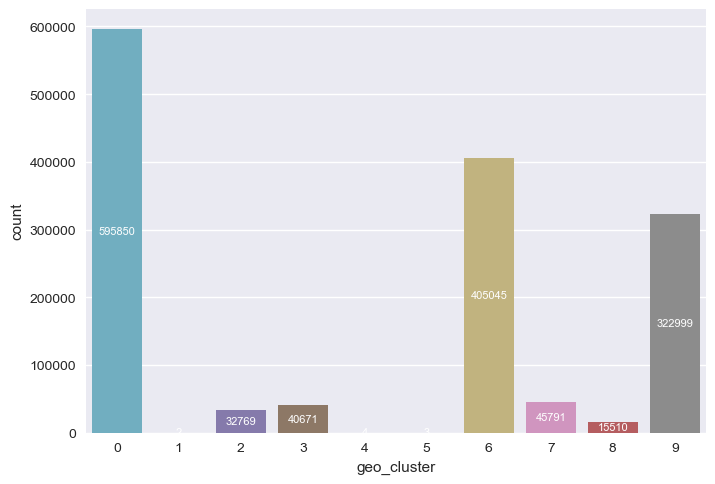

In [11]:
coords_1_8 = stage_1_df.iloc[:, 5:9].iloc[:, [1, 0, 3, 2]].to_numpy()

kmeans_1_8 = KMeans(n_clusters=10, random_state=42, n_init='auto')
kmeans_1_8.fit(coords_1_8)

stage_1_df['geo_cluster'] = kmeans_1_8.predict(coords_1_8)

bpftc = sns.barplot(stage_1_df['geo_cluster'].value_counts().reset_index(), x='geo_cluster', y='count', hue='count', palette='deep', legend=False)
[bpftc.bar_label(bpftc.containers[i], fmt='%.0f', label_type='center', color='white', fontsize=8) for i in range(len(bpftc.containers))];

[to contents](#contents)

<h3 id='weatherdf'>1.9</h3>

Реализуйте функцию `add_weather_features()`, которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о <a href='https://drive.google.com/file/d/1rgK8YuMp-AuV53LWiH-oDuprZmp9zt15/view?usp=drive_link'>погодных условиях</a> на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* `temperature` - температура;
* `visibility` - видимость;
* `wind speed` - средняя скорость ветра;
* `precip` - количество осадков;
* `events` - погодные явления.

1. Сколько поездок было совершено в снежную погоду?

В результате объединения у вас должны получиться записи, для которых в столбцах `temperature`, `visibility`, `wind speed`, `precip`, и `events` будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки. 

2. Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями? Ответ приведите с точностью до сотых процента.

Я снова не стал добавлять функцию, т.к. хз, чё в ней писать, если это всё пишется в 1 строку.

[обратно к преобразованию тест таблицы](#testdatapreparation)

In [12]:
weather_df = pd.read_csv('data/weather_data.csv')[['time', 'temperature', 'visibility', 'wind speed', 'precip', 'events']]
weather_df = add_datetime_features(weather_df, 'time').drop(columns='time').rename(columns={'time_date':'pickup_datetime_date', 'time_hour':'pickup_datetime_hour'})
weather_df['events'] = weather_df['events'].fillna('None')

stage_1_df = stage_1_df.merge(weather_df, how='left', on=['pickup_datetime_date', 'pickup_datetime_hour'])

print(f"В снежную погоду было совершено: {stage_1_df[stage_1_df['events'] == 'Snow'].shape[0]} поездок")
print(f"Пропуски составляют: {stage_1_df['events'].isna().mean()*100:.2f}%")

В снежную погоду было совершено: 13126 поездок
Пропуски составляют: 0.82%


В пункте 2 задания 1.9 видимо требовалось определить, скольким данным из основной таблицы не хватило таблицы с погодой. И вывести долю по одному столбцу. 12032 от 1.5кк = 0.82.

[to contents](#contents)

<h3 id='nanvalsinweather'>1.10</h3>

Реализуйте функцию `fill_null_weather_data()`, которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  `temperature`, `visibility`, `wind speed`, `precip` заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируйте данные по столбцу `pickup_date` и рассчитайте медиану в каждой группе, после чего с помощью комбинации методов `transform()` и `fillna()` заполните пропуски. 
Пропуски в столбце events заполните строкой '`None`' - символом отсутствия погодных явлений (снега/дождя/тумана). 

Пропуски в столбцах с информацией из OSRM API - `total_distance`, `total_travel_time` и `number_of_steps` заполните медианным значением по столбцам. 

Чему равна медиана в столбце `temperature` после заполнения пропусков? Ответ округлите до десятых.

[обратно к преобразованию тест таблицы](#testdatapreparation)

In [13]:
stage_1_df = fill_null_weather_data(stage_1_df)

print(f"Медиана в столбце с температурой = {stage_1_df['temperature'].median()}")

Медиана в столбце с температурой = 11.1


[to contents](#contents)

<h3 id='firstlogicaloutliers'>1.11</h3>

В завершение первой части найдём очевидные выбросы в целевой переменной — длительности поездки.

Проще всего найти слишком продолжительные поездки. Условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа.

Чуть сложнее с анализом поездок, длительность которых слишком мала, так как к ним относятся реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того, как включился счётчик, а также «телепортации» (перемещение на большие расстояния за считанные секунды).

Условимся, что будем считать выбросами только последнюю группу.

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. \
Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом: $avg\_speed= \frac{total\_distance}{1000 \cdot trip\_duration} \cdot 3600$ \
или $avg\_speed= \frac{total\_distance}{trip\_duration}$ если признаки уже приведены к `км` и `часы` соответственно.

Если построить диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:

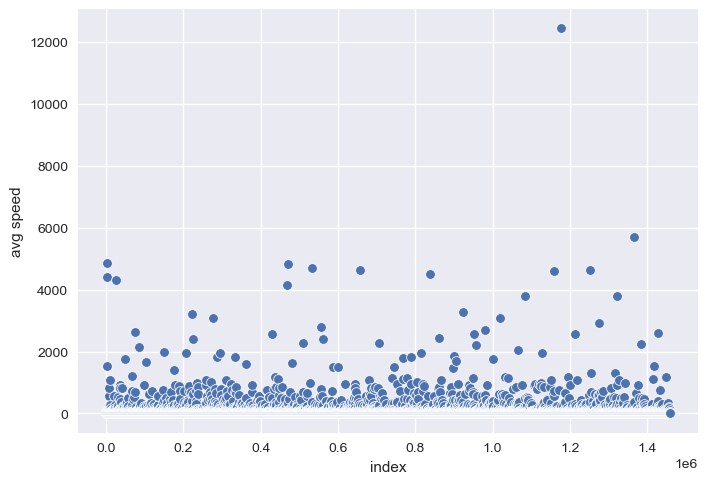

In [14]:
avg_speed = (stage_1_df['total_distance'] / (1000 * stage_1_df['trip_duration'])) * 3600

#avg_speed.drop(index=avg_speed[avg_speed > 300].index, inplace=True)
#avg_speed.drop(index=avg_speed[avg_speed < 10].index, inplace=True)

sns.scatterplot(x=avg_speed.index, y=avg_speed)
plt.xlabel('index')
plt.ylabel('avg speed');

Как раз отсюда мы видим, что у нас есть поездки-«телепортации», для которых средняя скорость составляет более 1000 км/ч. Есть даже поездка со средней скоростью более 12 000 км/ч!

Найдите поездки, длительность которых превышает 24 часа, и удалите их из набора данных.
1. Сколько выбросов по признаку длительности поездки вам удалось найти?

Найдите поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалите их из данных.

2. Сколько выбросов по признаку скорости вам удалось найти?

In [15]:
time_outliers = stage_1_df[stage_1_df['trip_duration'] / 3600 > 24]
speed_outliers = avg_speed[avg_speed > 300]

print(f"1. Обнаружено {time_outliers.shape[0]} поездки, длительность которых превысила 24 часа")
print(f"2. Обнаружено {speed_outliers.shape[0]} поездки, скорость которых превысила 300 км/ч")

stage_1_df = stage_1_df.drop(index=np.append(time_outliers.index, speed_outliers.index)).reset_index(drop=True)

1. Обнаружено 4 поездки, длительность которых превысила 24 часа
2. Обнаружено 407 поездки, скорость которых превысила 300 км/ч


<h2 style='text-align:center;'>Разведывательный анализ данных (EDA)</h2>

In [16]:
stage_2_df = stage_1_df.copy()
stage_2_df['trip_duration_log'] = np.log(stage_2_df['trip_duration'] + 1)

[to contents](#contents)

<h3 id='normaltestoftargft'>2.1</h3>

Постройте гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (`trip_duration_log`). \
Исходя из визуализации, сделайте предположение, является ли полученное распределение нормальным? \
Проверьте свою гипотезу с помощью `теста Д’Агостино` при уровне значимости $\alpha=0.05$. 

1. Чему равен вычисленный `p-value`? Ответ округлите до сотых.
2. Является ли распределение длительности поездок в логарифмическом масштабе нормальным?

0.0 < 0.05, отвергаем Н0, распределение отлично от нормального


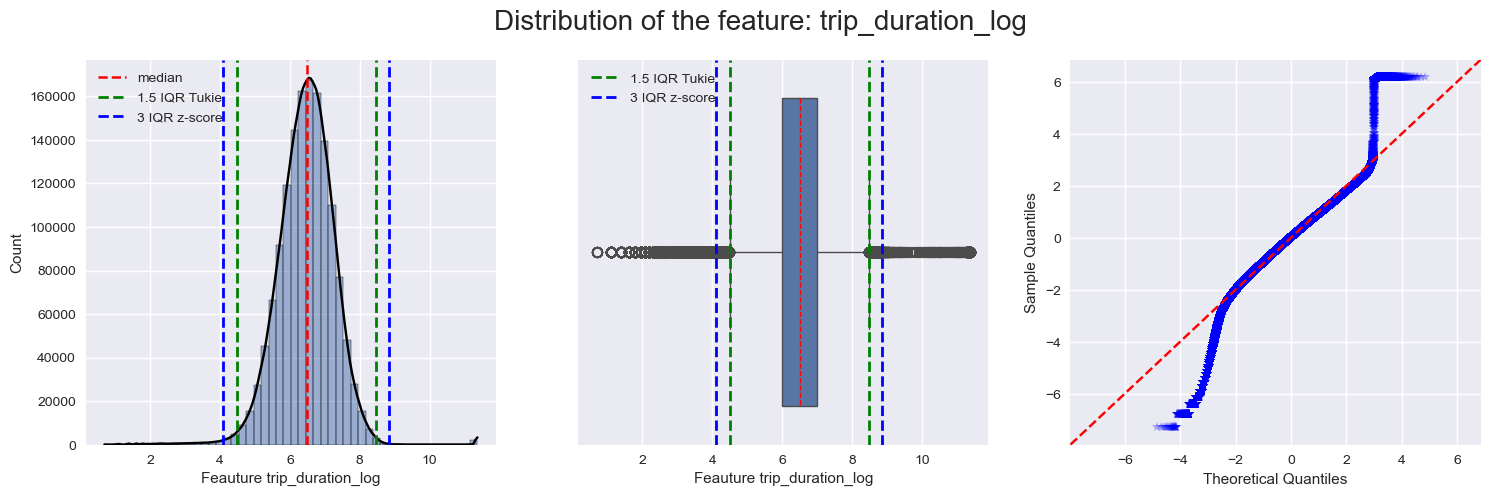

In [17]:
alpha = 0.05
print(f"{stats.normaltest(stage_2_df['trip_duration_log'])[1]} < {alpha}, отвергаем Н0, распределение отлично от нормального")

hist_box_qq(stage_2_df['trip_duration_log'], full_iqr=True);

[to contents](#contents)

<h3 id='vendorvstarget'>2.2</h3>

Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (`trip_duration_log`) в зависимости от таксопарка (`vendor_id`). 

Сравните два распределения между собой.

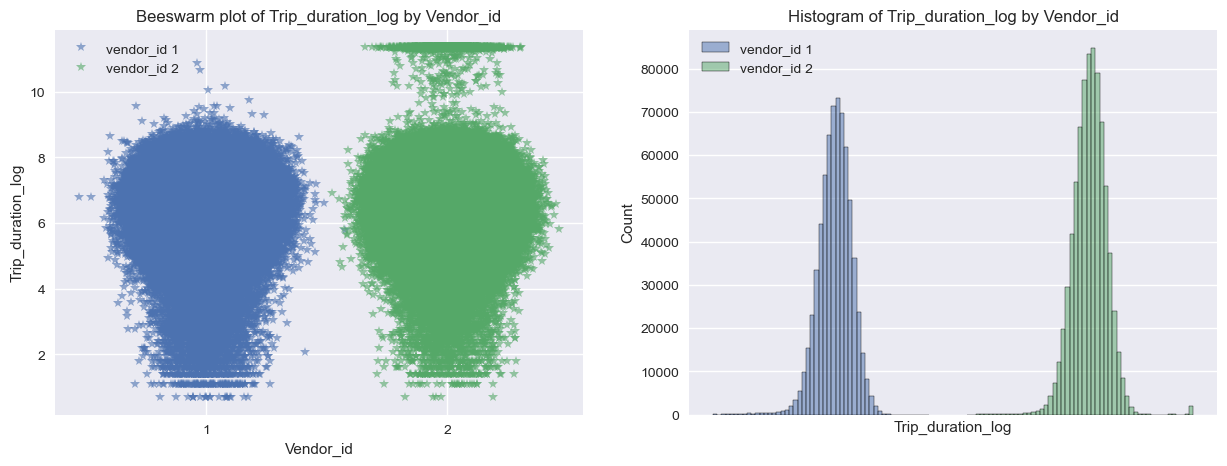

In [18]:
df_for_this_cell = stage_2_df.copy() #[stage_2_df['trip_duration'] < 30000]

swarm_hist(df_for_this_cell, 'trip_duration_log', 'vendor_id').show()

del df_for_this_cell

Курс принял ответ: "Распределения в группах практически не отличаются, признак `vendor_id` не имеет значения при определении длительности поездки." В принципе гистограммы как раз и говорят об этом, что не так уж сильно признак `vendor_id` влияет на определение длительности поездки. Но по левому графику, на мой взгляд, наблюдается некоторое количество выбросов, которые мы не учли, когда отсеивали выбросы в [п.1.11](#firstlogicaloutliers).

Например есть 1502 поездки, которые приблизительно равняются 24 часам. Именно эти поездки и образуют `тучку` на левом графике.

In [19]:
(stage_2_df.loc[stage_2_df['trip_duration'] > 85000, 'trip_duration'] / 3600).sort_values(ascending=False)

1233934    23.997778
295293     23.997500
73794      23.997222
59873      23.996389
1360047    23.995833
             ...    
1345337    23.615000
1177164    23.614444
352703     23.614167
834672     23.613056
1446097    23.611667
Name: trip_duration, Length: 1502, dtype: float64

[to contents](#contents)

<h3 id='safflvstripdur'>2.3</h3>

Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (`trip_duration_log`) в зависимости от признака отправки сообщения поставщику (`store_and_fwd_flag`). 

Сравните два распределения между собой.

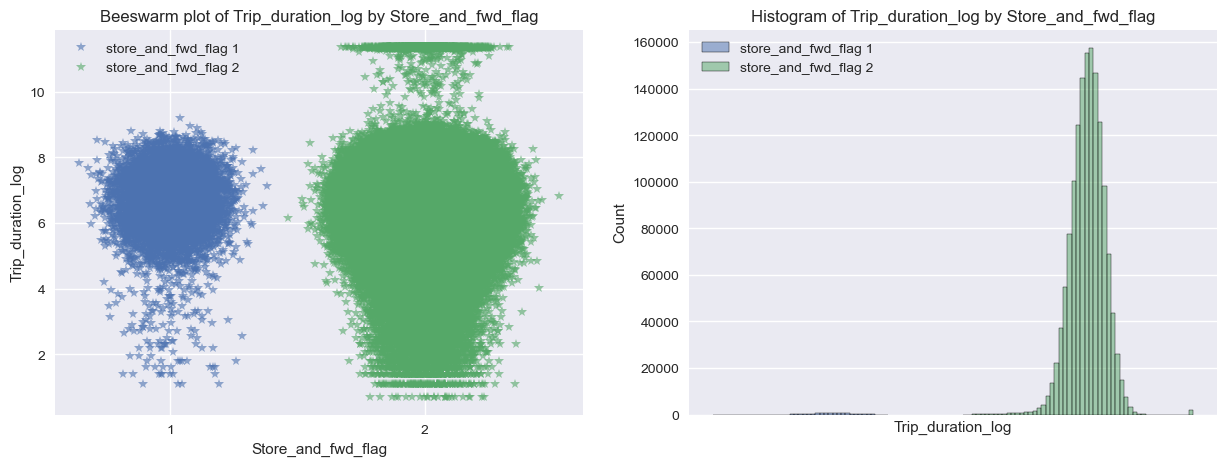

In [20]:
# Чтобы можно было проверить отсечение потенциальных выбросов
df_for_this_cell = stage_2_df.copy() #[stage_2_df['trip_duration'] < 30000]
df_for_this_cell['store_and_fwd_flag'] = df_for_this_cell['store_and_fwd_flag'].apply(lambda x: 2 if x == 'N' else 1)

swarm_hist(df_for_this_cell, 'trip_duration_log', 'store_and_fwd_flag').show()

del df_for_this_cell

Платформа приняла ответ: "Распределения в группах значительно отличаются, признак `store_and_fwd_flag` имеет значение при определении длительности поездки." 

И даже есть вот такое примечание:

>Примечание. Если внимательно присмотреться к распределению длительности поездок в зависимости от признака `store_and_fwd_flag`, становится ясно, что наиболее длительные поездки принадлежат к группе `N` (не хранить и не пересылать поездку). Таким образом, флаг сохраняется только для кратковременных поездок, а для аномальных многочасовых — не сохраняется.

Но я (новичок в мире датасаенс) бы такой признак удалил, т.к. пропорция данных - дикая и признак считай сплошной.

In [21]:
(stage_2_df['store_and_fwd_flag'].value_counts(normalize=True) * 100).round(2)

store_and_fwd_flag
N    99.45
Y     0.55
Name: proportion, dtype: float64

[to contents](#contents)

<h3 id='dependenciesbytime'>2.4</h3>

Постройте две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

На основе построенных графиков ответьте на следующие вопросы:

1. В какое время суток такси заказывают реже всего?
2. В какое время суток наблюдается пик медианной длительности поездок?

Реже всего заказывают такси с 00.00 по 5.00 часов утра
Пик медианной длительности наблюдается с 13.00 по 18.00 часов дня


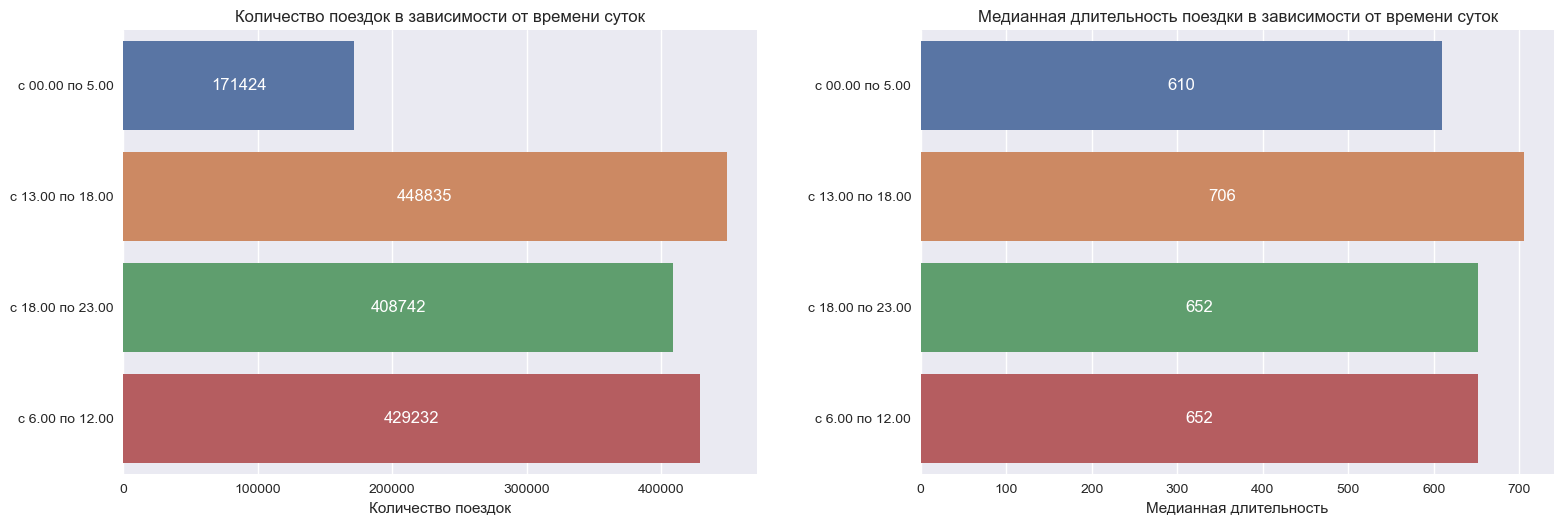

In [22]:
df_for_this_cell_1 = func_for_2_4(stage_2_df, 'pickup_datetime_hour').groupby('pickup_datetime_hour')['trip_duration'].count()
df_for_this_cell_2 = func_for_2_4(stage_2_df, 'pickup_datetime_hour').groupby('pickup_datetime_hour')['trip_duration'].median()

fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

fig.tight_layout(w_pad=9) # расстояние между подграфиками

sns.barplot(y=df_for_this_cell_1.index, x=df_for_this_cell_1, hue=df_for_this_cell_1.index, orient='h', ax=ax[0], palette='deep')
sns.barplot(y=df_for_this_cell_2.index, x=df_for_this_cell_2, hue=df_for_this_cell_2.index, orient='h', ax=ax[1], palette='deep')

[ax[0].bar_label(ax[0].containers[i], fmt='%.0f', label_type='center', color='white', fontsize=12) for i in range(len(df_for_this_cell_1.index))]
[ax[1].bar_label(ax[1].containers[i], fmt='%.0f', label_type='center', color='white', fontsize=12) for i in range(len(df_for_this_cell_2.index))]

ax[0].set_ylabel(''), ax[0].set_xlabel('Количество поездок')
ax[1].set_ylabel(''), ax[1].set_xlabel('Медианная длительность')

ax[0].set_title('Количество поездок в зависимости от времени суток')
ax[1].set_title('Медианная длительность поездки в зависимости от времени суток')

print(f"Реже всего заказывают такси {df_for_this_cell_1[df_for_this_cell_1 == df_for_this_cell_1.min()].index[0]} часов утра")
print(f"Пик медианной длительности наблюдается {df_for_this_cell_2[df_for_this_cell_2 == df_for_this_cell_2.max()].index[0]} часов дня")

del df_for_this_cell_1, df_for_this_cell_2

[to contents](#contents)

<h3 id='dependenciesbydayofweek'>2.5</h3>

Постройте две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

На основе построенных графиков ответьте на следующие вопросы:
1. В какой день недели совершается больше всего поездок?
2. В какой день недели медианная длительность поездок наименьшая?

Чаще всего заказывают такси в Friday
Наименьшая медианная длительность наблюдается в Sunday


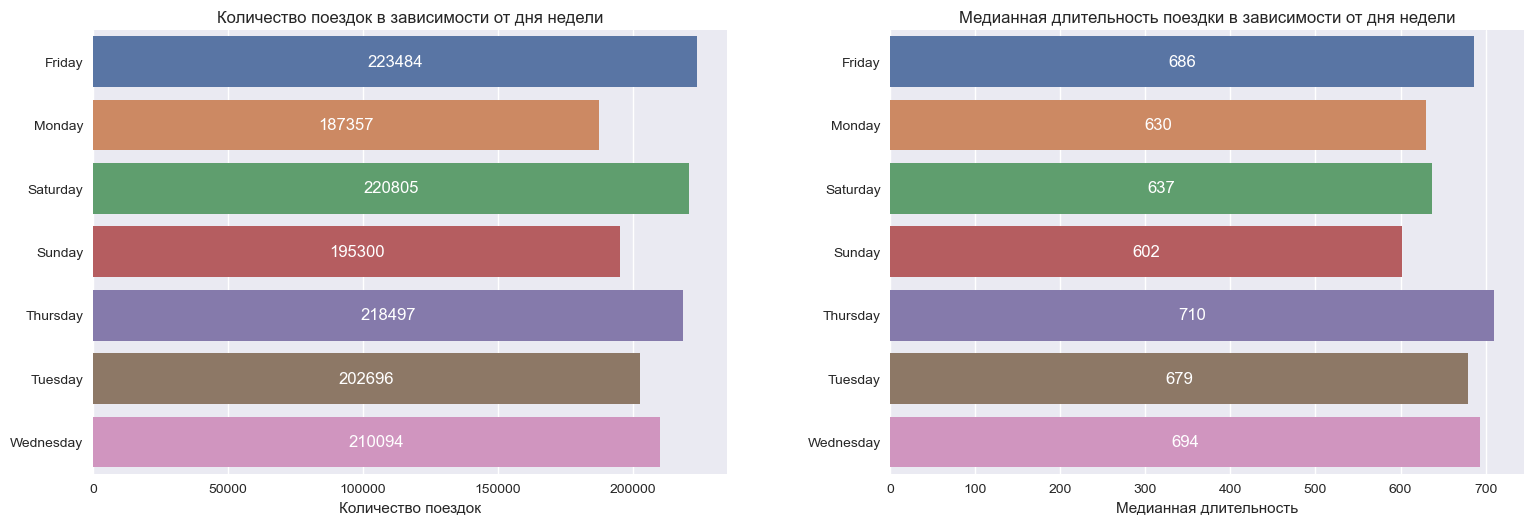

In [23]:
df_for_this_cell_1 = stage_2_df.groupby('pickup_datetime_day_of_week')['trip_duration'].count()
df_for_this_cell_2 = stage_2_df.groupby('pickup_datetime_day_of_week')['trip_duration'].median()

fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

fig.tight_layout(w_pad=9) # расстояние между подграфиками

sns.barplot(y=df_for_this_cell_1.index, x=df_for_this_cell_1, hue=df_for_this_cell_1.index, orient='h', ax=ax[0], palette='deep')
sns.barplot(y=df_for_this_cell_2.index, x=df_for_this_cell_2, hue=df_for_this_cell_2.index, orient='h', ax=ax[1], palette='deep')

[ax[0].bar_label(ax[0].containers[i], fmt='%.0f', label_type='center', color='white', fontsize=12) for i in range(len(df_for_this_cell_1.index))]
[ax[1].bar_label(ax[1].containers[i], fmt='%.0f', label_type='center', color='white', fontsize=12) for i in range(len(df_for_this_cell_2.index))]

ax[0].set_ylabel(''), ax[0].set_xlabel('Количество поездок')
ax[1].set_ylabel(''), ax[1].set_xlabel('Медианная длительность')

ax[0].set_title('Количество поездок в зависимости от дня недели')
ax[1].set_title('Медианная длительность поездки в зависимости от дня недели')

print(f"Чаще всего заказывают такси в {df_for_this_cell_1[df_for_this_cell_1 == df_for_this_cell_1.max()].index[0]}")
print(f"Наименьшая медианная длительность наблюдается в {df_for_this_cell_2[df_for_this_cell_2 == df_for_this_cell_2.min()].index[0]}")

del df_for_this_cell_1, df_for_this_cell_2

[to contents](#contents)

<h3 id='pickuphourvspickupdayofweek'>2.6</h3>

Посмотрим на обе временные характеристики одновременно. 

Постройте сводную таблицу, по строкам которой отложены часы (`pickup_hour`), по столбцам - дни недели (`pickup_day_of_week`), а в ячейках - медианная длительность поездки (`trip_duration`). 

Визуализируйте полученную сводную таблицу с помощью тепловой карты и выберите все верные варианты ответа..

<span style='color:green'>A</span>. Самые продолжительные поездки (в медианном смысле) наблюдаются с понедельника по пятницу в промежутке с 8 до 18 часов.\
<span style='color:green'>B</span>. Наибольшая медианная длительность поездки наблюдалась в четверг в 14 часов дня.\
<span style='color:red'>C</span>. Наибольшая медианная длительность поездки наблюдалась в понедельник в 17 часов дня.\
<span style='color:red'>D</span>. Самые продолжительные поездки (в медианном смысле) наблюдаются с понедельника по пятницу в промежутке с 4 до 8 часов. 

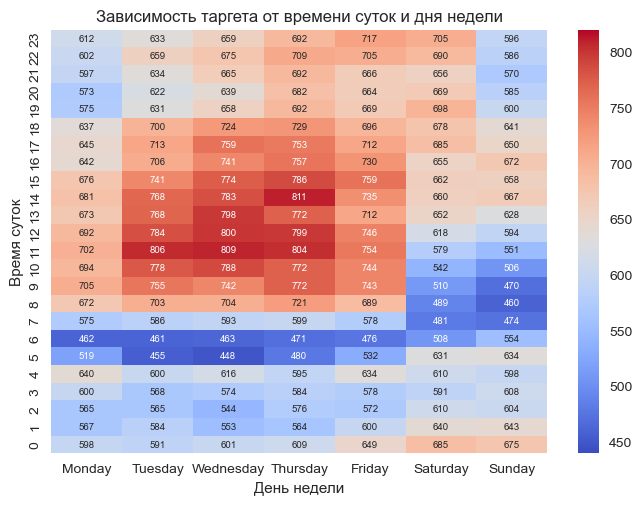

In [24]:
df_for_this_cell = pd.pivot_table(stage_2_df, index='pickup_datetime_hour', columns='pickup_datetime_day_of_week', values='trip_duration', aggfunc='median').iloc[::-1, [1, 5, 6, 4, 0, 2, 3]]

sns.heatmap(df_for_this_cell, cmap='coolwarm', annot=True, fmt='.0f', annot_kws={'size':'x-small'}, vmin=440, vmax=820)

plt.title('Зависимость таргета от времени суток и дня недели')
plt.xlabel('День недели')
plt.ylabel('Время суток');

[to contents](#contents)

<h3 id='scatteroflatlong'>2.7</h3>

Постройте две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (`pickup_longitude`, `pickup_latitude`) 
* вторая должна географическое расположение точек завершения поездок (`dropoff_longitude`, `dropoff_latitude`).

Для этого на диаграммах по оси абсцисс отложите широту (`longitude`), а по оси ординат - долготу (`latitude`). 
Включите в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:
 
`city_long_border` = (-74.03, -73.75)

`city_lat_border` = (40.63, 40.85)

Добавьте на диаграммы расцветку по десяти географическим кластерам (`geo_cluster`), которые мы сгенерировали ранее. 

<b>Сколько кластеров (из десяти) не попало на диаграммы (находятся за границами Нью-Йорка)?</b> \
(Вот здесь есть зависимость от `random_state` в ячейке, где [били кластеры](#geoclustering)) 

В данном задании мой ответ не сошёлся с ответом курса. В курсе ответ 2, у меня 3. Зависит от кластеров. Если при кластеризации поставить `random_state`=108, то ответ сойдётся. Но не сойдутся ответы в метриках. Так что тут выбор.

3 кластера не попали на диаграммы


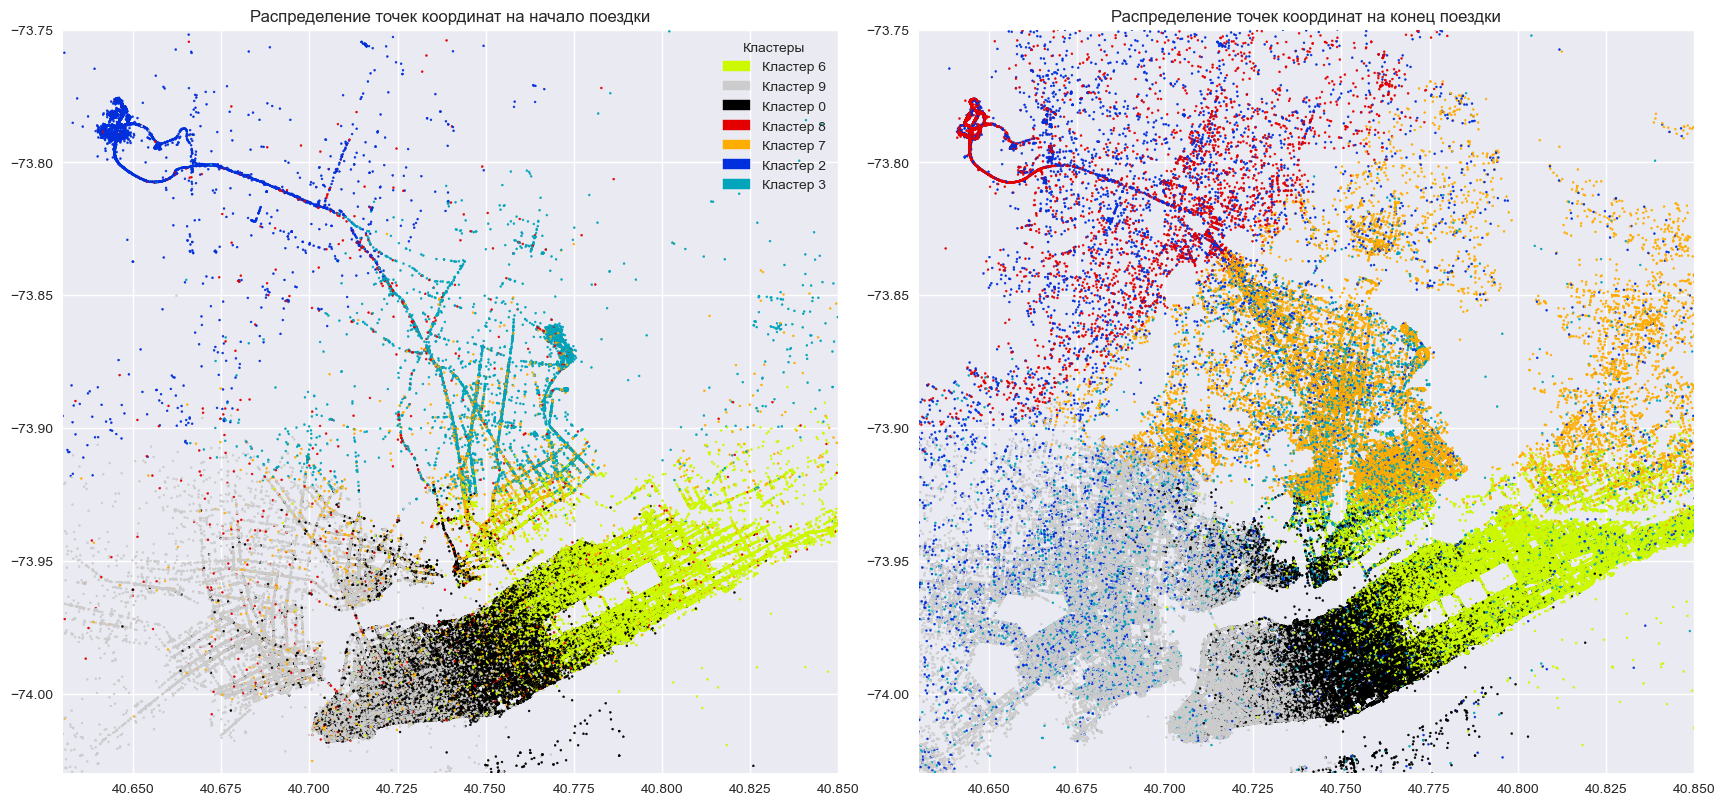

In [25]:
long_border_2_7 = (-74.03, -73.75)
lat_border_2_7 = (40.63, 40.85)

df_ftc = stage_2_df[stage_2_df['pickup_latitude'].between(*lat_border_2_7) & stage_2_df['pickup_longitude'].between(*long_border_2_7)]

print(f"{stage_2_df['geo_cluster'].nunique() - df_ftc['geo_cluster'].nunique()} кластера не попали на диаграммы")

######################################

fig, ax = plt.subplots(ncols=2, figsize=(17, 8))
fig.tight_layout(w_pad=3)  # расстояние между подграфиками

# График для координат начала поездки
scatter_2_7_pickup = ax[0].scatter(df_ftc['pickup_latitude'], 
                                   df_ftc['pickup_longitude'], 
                                   c=df_ftc['geo_cluster'], 
                                   s=2, cmap='nipy_spectral')

# График для координат конца поездки
scatter_2_7_dropoff = ax[1].scatter(df_ftc['dropoff_latitude'], 
                                    df_ftc['dropoff_longitude'], 
                                    c=df_ftc['geo_cluster'], 
                                    s=2, cmap='nipy_spectral')

# Получаем уникальные кластеры и цвета
unique_clusters = df_ftc['geo_cluster'].unique()
colors = [scatter_2_7_pickup.cmap(scatter_2_7_pickup.norm(cluster)) for cluster in unique_clusters]

# Создаем легенду с метками кластеров
legend_patches = [mpatches.Patch(color=colors[i], label=f'Кластер {unique_clusters[i]}') for i in range(len(unique_clusters))]
ax[0].legend(handles=legend_patches, title='Кластеры', loc='upper right', bbox_to_anchor=(1, 1))

# Устанавливаем границы и заголовки
ax[0].set_xlim(lat_border_2_7), ax[1].set_xlim(lat_border_2_7)
ax[0].set_ylim(long_border_2_7), ax[1].set_ylim(long_border_2_7)

ax[0].set_title('Распределение точек координат на начало поездки')
ax[1].set_title('Распределение точек координат на конец поездки')

plt.show()

del df_ftc

<h2 style='text-align:center;'>Отбор и преобразование признаков</h2>

In [26]:
print(f'Shape of data: {stage_2_df.shape}')
print(f'Columns: {stage_2_df.columns}')

stage_3_df = stage_2_df.copy()

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_datetime_date', 'pickup_datetime_hour',
       'pickup_datetime_day_of_week', 'holiday', 'total_distance',
       'total_travel_time', 'number_of_steps', 'haversine_distance',
       'direction', 'geo_cluster', 'temperature', 'visibility', 'wind speed',
       'precip', 'events', 'trip_duration_log'],
      dtype='object')


[to contents](#contents)

<h3 id='dataleakandnoninform'>3.1</h3>

Сразу позаботимся об очевидно неинформативных и избыточных признаках.

1. Какой из указанных ниже признаков является уникальным для каждой поездки и не несёт полезной информации в определении её продолжительности? (`id`)
2. Наличие какого из указанных ниже признаков в обучающем наборе данных создаёт утечку данных? (`dropoff_datetime` т.к. — это зафиксированное время остановки счётчика. Начиная поездку, мы никак не можем точно знать, когда она закончится, ведь мы как раз и пытаемся предсказать время окончания поездки.)
3. Исключите признаки, выбранные в пунктах 1 и 2, из исходной таблицы с данными. Сколько столбцов осталось в таблице?

Так же мы можем избавиться от `признаков даты начала поездки`, т.к. мы извлекли всю необходимую информацию.

[обратно к преобразованию тест таблицы](#testdatapreparation)

In [27]:
stage_3_df = stage_3_df.drop(columns=['id', 'dropoff_datetime'])
print(f"В таблице осталось {stage_3_df.shape[1]} стобцов")

stage_3_df = stage_3_df.drop(columns=['pickup_datetime', 'pickup_datetime_date'])

В таблице осталось 25 стобцов


[to contents](#contents)

<h3 id='vendorflagencoding'>3.2</h3>

Теперь займёмся кодированием категориальных признаков. В наших данных к категориальным можно отнести следующие признаки:

* vendor_id;
* store_and_fwd_flag;
* pickup_day_of_week;
* geo_cluster;
* events.

Первые два (`vendor_id` и `store_and_fwd_flag`) из них являются бинарными (имеют два уникальных значения)


* Закодируйте признак `vendor_id` таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 1 — в противном случае.
* Закодируйте признак `store_and_fwd_flag` таким образом, чтобы он был равен 0, если флаг выставлен в значение 'N', и 1 — в противном случае.

1. Рассчитайте среднее по закодированному столбцу `vendor_id`. Ответ округлите до второго знака после точки-разделителя.
2. Рассчитайте среднее по закодированному столбцу `store_and_fwd_flag`. Ответ округлите до третьего знака после точки-разделителя.

[обратно к преобразованию тест таблицы](#testdatapreparation)

In [28]:
# xDD С вендором забавно. Там два уникальных значения: 1 и 2. И надо сделать из единицы - 0, а из двойки - единицу.)))
stage_3_df['vendor_id'] -= 1
stage_3_df['store_and_fwd_flag'] = stage_3_df['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)

print(f"Среднее по vendor_id = {stage_3_df['vendor_id'].mean().round(2)}")
print(f"Среднее по store_and_fwd_flag = {stage_3_df['store_and_fwd_flag'].mean().round(3)}")

Среднее по vendor_id = 0.53
Среднее по store_and_fwd_flag = 0.006


[to contents](#contents)

<h3 id='pickupdayofweekgeoclustereventsenco'>3.3</h3>

Создайте таблицу `data_onehot` из закодированных однократным кодированием признаков `pickup_day_of_week`, `geo_cluster` и `events` с помощью `OneHotEncoder()`. В качестве значения параметра `drop` возьмите '`first`', чтобы удалять первый бинарный столбец и тем самым не создавать излишних признаков.

В параметре `handle_unknown` установите значение '`ignore`'. Это позволит коду отработать без ошибок в случае появления в тестовой выборке значений, отсутствующих в обучающей выборке.

Сколько бинарных столбцов у вас получилось сгенерировать с помощью однократного кодирования?

[обратно к преобразованию тест таблицы](#testdatapreparation)

In [29]:
columns_to_encode = ['pickup_datetime_day_of_week', 'geo_cluster', 'events']

onehot_3_3 = OneHotEncoder(drop='first', handle_unknown='ignore')
onehot_3_3_matrix = onehot_3_3.fit_transform(stage_3_df[columns_to_encode]).toarray()

print(f"При однократном кодировании получилось {onehot_3_3_matrix.shape[1]} столбцов")

stage_3_df = pd.concat([stage_3_df.drop(columns=columns_to_encode), pd.DataFrame(onehot_3_3_matrix, columns=onehot_3_3.get_feature_names_out())], axis=1)

При однократном кодировании получилось 18 столбцов


[to contents](#contents)

<h3 id='xyhere'>Здесь находится X и y</h3>

Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений `X`, вектор целевой переменной `y` и его логарифм `y_log`. В матрицу наблюдений войдут все столбцы из таблицы с поездками, за исключением целевого признака `trip_duration` и его логарифмированной версии `trip_duration_log`.

Все наши модели мы будем обучать на логарифмированной версии `y_log`.

Так же нам необходимо определить тип валидации — схему, по которой мы будем оценивать качество построенных моделей. Так как наш набор данных довольно большой (почти 1.5 миллиона наблюдений), то мы свободно можем использовать `hold-out`-валидацию. Использование `k-fold`-валидации и тем более `leave-one-out`-валидации при таком объёме данных будет избыточным и времязатратным.

Разобьём выборку на обучающую и валидационную в соотношении 67/33.

In [30]:
X = stage_3_df.drop(columns=['trip_duration', 'trip_duration_log'])
y = stage_3_df['trip_duration']
y_log = stage_3_df['trip_duration_log']

X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.33, random_state=42)

На данный момент у нас достаточно много признаков — скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели ↓

[to contents](#contents)

<h3 id='selectkbestselection'>3.4</h3>

С помощью `SelectKBest` отберите 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуйте по обучающей выборке, используя параметр `score_func = f_regression`.

В тренировочной и валидационной выборке оставьте только полученные 25 признаков, откинув ненужные. Далее мы будем работать и строить модели на отобранных признаках.
Укажите признаки, которые вошли в список отобранных:

<span style='color:green'>vendor_id</span>, <span style='color:green'>passenger_count</span>, <span style='color:green'>number_of_steps</span>, <span style='color:green'>temperature</span>, <span style='color:red'>events_None</span>, <span style='color:red'>visibility</span>, <span style='color:red'>wind speed</span>

[обратно к преобразованию тест таблицы](#testdatapreparation)

Признаки, не вошедшие в топ25: ['events_None', 'visibility', 'wind speed']


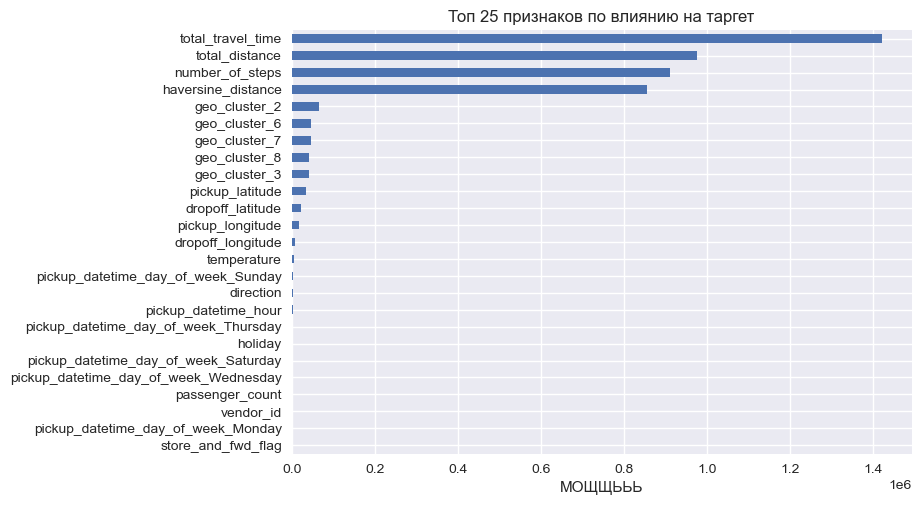

In [31]:
selectkbest_3_4 = SelectKBest(score_func=f_regression, k=25).fit(X, y_log)

best_features_3_4 = X.iloc[:, selectkbest_3_4.get_support()].columns

X_train = pd.DataFrame(selectkbest_3_4.transform(X_train), columns=best_features_3_4)
X_test = pd.DataFrame(selectkbest_3_4.transform(X_test), columns=best_features_3_4)

print(f"Признаки, не вошедшие в топ25: {[i for i in ['vendor_id','passenger_count','number_of_steps','temperature','events_None','visibility','wind speed'] if i not in X_train.columns]}")

pd.Series(selectkbest_3_4.scores_[selectkbest_3_4.get_support()], index=best_features_3_4).sort_values().plot(kind='barh')
plt.title('Топ 25 признаков по влиянию на таргет')
plt.xlabel("МОЩЩЬЬЬ");

[to contents](#contents)

<h3 id='normalizationofx'>3.5</h3>

Нормализуйте предикторы в обучающей и валидационной выборках с помощью `MinMaxScaler` из библиотеки `sklearn`.

Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки. Ответ округлите до сотых.

[обратно к преобразованию тест таблицы](#testdatapreparation)

In [32]:
scaler_3_5 = MinMaxScaler()
scaler_3_5.fit(X_train)

X_train_scaled = scaler_3_5.transform(X_train)
X_test_scaled = scaler_3_5.transform(X_test)

print(f"Среднее арифметическое для необходимого предиктора: {X_test_scaled[:, 0].mean().round(2)}")

Среднее арифметическое для необходимого предиктора: 0.54


<h2 style='text-align:center;'>Решение задачи регрессии: линейная регрессия и деревья решений</h2>

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 

[to contents](#contents)

<h3 id='basiclinreg'>4.1</h3>

Постройте модель линейной регрессии на обучающей выборке. Все параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику `RMSLE` на тренировочной и валидационной выборках. Ответ округлите до сотых.

Метрики, принимаемые платформой, должны быть взяты <span style='color:red'>в экспоненту</span>.

In [33]:
model_4_1 = LinearRegression()
model_4_1.fit(X_train_scaled, y_train)

print_metrics(y_train=np.expm1(y_train),
              y_train_pred=[np.expm1(np.abs(model_4_1.predict(X_train_scaled)))],
              y_test=np.expm1(y_test),
              y_test_pred=[np.expm1(np.abs(model_4_1.predict(X_test_scaled)))],
              list_of_metrics=['root_mean_squared_log_error', 'mean_absolute_error', 'root_mean_squared_error']).round(2)

,train,test
,0,0
RMSLE,0.53,0.54
MAE,424.33,435.71
RMSE,3786.78,4798.20


[to contents](#contents)

<h3 id='linregpoly'>4.2</h3>

Сгенерируйте полиномиальные признаки 2-ой степени с помощью `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` выставите в значение `False`.

Постройте модель полиномиальной регрессии 2-ой степени на обучающей выборке. Все параметры оставьте по умолчанию.

1. Для полученной модели рассчитайте метрику `RMSLE` на тренировочной и валидационной выборках. Ответ округлите до сотых.
2. Наблюдаются ли у вашей модели признаки переобучения? <span style='color:green'>Да, наблюдаются</span>

In [34]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)

X_train_poly = poly.transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

In [35]:
model_for_poly = LinearRegression(n_jobs=-1)
model_for_poly.fit(X_train_poly, y_train)

print_metrics(y_train=np.expm1(y_train),
              y_train_pred=[np.expm1(np.abs(model_for_poly.predict(X_train_poly)))],
              y_test=np.exp(y_test),
              y_test_pred=[np.exp(np.abs(model_for_poly.predict(X_test_poly)))],
              list_of_metrics=['root_mean_squared_log_error', 'mean_absolute_error', 'root_mean_squared_error']).round(2)

,train,test
,0,0
RMSLE,0.46,6.300000e-01
MAE,343.58,5.941005e+79
RMSE,3137.48,4.121261e+82


[to contents](#contents)

<h3 id='ltworegul'>4.3</h3>

Постройте модель полиномиальной регрессии 2-ой степени с `L2`-регуляризацией (регуляризация по Тихонову) на обучающей выборке. Коэффициент регуляризации $\alpha$ установите равным 1, остальные параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику `RMSLE` на тренировочной и валидационной выборках. Ответ округлите до сотых.

In [36]:
model_ridge = Ridge(alpha=1)
model_ridge.fit(X_train_poly, y_train)

print_metrics(y_train=np.expm1(y_train),
              y_train_pred=[np.expm1(np.abs(model_ridge.predict(X_train_poly)))],
              y_test=np.expm1(y_test),
              y_test_pred=[np.expm1(np.abs(model_ridge.predict(X_test_poly)))],
              list_of_metrics=['root_mean_squared_log_error', 'mean_absolute_error', 'root_mean_squared_error']).round(2)

,train,test
,0,0
RMSLE,0.48,0.48
MAE,353.11,456.90
RMSE,3304.99,65378.09


[to contents](#contents)

<h3 id='treeregressorbasic'>4.4</h3>

Постройте модель дерева решений (`DecisionTreeRegressor`) на обучающей выборке. Все параметры оставьте по умолчанию. 

1. Для полученной модели рассчитайте метрику `RMSLE` на тренировочной и валидационной выборках. Ответ округлите до сотых.
2. Наблюдаются ли у вашей модели признаки переобучения? <span style='color:green'>Наблюдается</span>

In [37]:
model_tree = DecisionTreeRegressor(random_state=42)
model_tree.fit(X_train_scaled, y_train)

print_metrics(y_train=np.expm1(y_train),
              y_train_pred=[np.expm1(np.abs(model_tree.predict(X_train_scaled)))],
              y_test=np.expm1(y_test),
              y_test_pred=[np.expm1(np.abs(model_tree.predict(X_test_scaled)))],
              list_of_metrics=['root_mean_squared_log_error', 'mean_absolute_error', 'root_mean_squared_error']).round(2)

,train,test
,0,0
RMSLE,0.00,0.56
MAE,0.01,530.70
RMSE,3.64,4781.61


[to contents](#contents)

<h3 id='treeregressorvsmaxdepth'>4.5</h3>

Переберите все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

`max_depths = range(7, 20)`

Параметр `random_state` задайте равным 42.

Постройте линейные графики изменения метрики `RMSE` на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений. 

1. Найдите оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение `RMSLE` на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

2. Чему равно значение метрик `RMSLE` на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной? Ответ округлите до сотых.

Миниммальное значение RMSLE на тестовой выборке наблюдается на глубине: 11


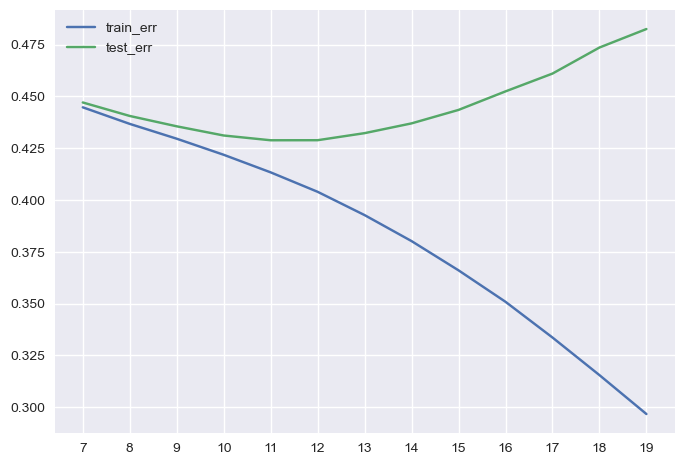

In [38]:
train_list = []
test_list = []
max_depths = range(7, 20)

for i in max_depths:
    model_tree = DecisionTreeRegressor(max_depth=i, random_state=42)
    model_tree.fit(X_train_scaled, y_train)

    train_list.append(root_mean_squared_log_error(np.expm1(y_train), np.expm1(model_tree.predict(X_train_scaled))))
    test_list.append(root_mean_squared_log_error(np.expm1(y_test), np.expm1(model_tree.predict(X_test_scaled))))

print(f"Миниммальное значение RMSLE на тестовой выборке наблюдается на глубине: {pd.Series(test_list, index=max_depths).idxmin()}")
    
sns.lineplot(pd.Series(train_list, index=max_depths), label='train_err')
sns.lineplot(pd.Series(test_list, index=max_depths), label='test_err')
plt.xticks(max_depths);

In [39]:
model_tree = DecisionTreeRegressor(max_depth=pd.Series(test_list, index=max_depths).idxmin(), random_state=42)
model_tree.fit(X_train_scaled, y_train)

print_metrics(y_train=np.expm1(y_train),
              y_train_pred=[np.expm1(np.abs(model_tree.predict(X_train_scaled)))],
              y_test=np.expm1(y_test),
              y_test_pred=[np.expm1(np.abs(model_tree.predict(X_test_scaled)))],
              list_of_metrics=['root_mean_squared_log_error', 'mean_absolute_error', 'root_mean_squared_error']).round(2)

,train,test
,0,0
RMSLE,0.41,0.43
MAE,310.40,328.43
RMSE,3020.74,3223.15


<h2 style='text-align:center;'>Решение задачи регрессии: ансамбли моделей и построение прогноза</h2>

[to contents](#contents)

<h3 id='randomforest'>5.1</h3>

Постройте модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* `n_estimators` = 200,
* `max_depth` = 12,
* `criterion` = 'squared_error',
* `min_samples_split` = 20,
* `random_state` = 42

Для полученной модели рассчитайте метрику `RMSLE` на тренировочной и валидационной выборках. Ответ округлите до сотых.

Ячейка отрабатывает за 19 минут. C `n_jobs=-1` - за 5.

In [40]:
model_5_1 = RandomForestRegressor(n_estimators=200,
                                  max_depth=12,
                                  criterion='squared_error',
                                  min_samples_split=20,
                                  random_state=42, n_jobs=-1)
model_5_1.fit(X_train_scaled, y_train)

print_metrics(y_train=np.expm1(y_train),
              y_train_pred=[np.expm1(np.abs(model_5_1.predict(X_train_scaled)))],
              y_test=np.expm1(y_test),
              y_test_pred=[np.expm1(np.abs(model_5_1.predict(X_test_scaled)))],
              list_of_metrics=['root_mean_squared_log_error', 'mean_absolute_error', 'root_mean_squared_error']).round(2)

,train,test
,0,0
RMSLE,0.40,0.41
MAE,304.35,312.73
RMSE,3086.89,3157.68


[to contents](#contents)

<h3 id='gradientboosting'>5.2</h3>

Постройте модель градиентного бустинга над деревьями решений (`GradientBoostingRegressor`) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:

* `learning_rate` = 0.5,
* `n_estimators` = 100,
* `max_depth` = 6, 
* `min_samples_split` = 30,
* `random_state` = 42

Для полученной модели рассчитайте метрику `RMSLE` на тренировочной и валидационной выборках. Ответ округлите до сотых.

Время работы ячейки (моей) 7.22 мин.

[обратно к предсказанию](#predictionvssubmission)

In [41]:
model_5_2 = GradientBoostingRegressor(learning_rate=0.5,
                                      n_estimators=100,
                                      max_depth=6,
                                      min_samples_split=30,
                                      random_state=42)
model_5_2.fit(X_train_scaled, y_train)

print_metrics(y_train=np.expm1(y_train),
              y_train_pred=[np.expm1(np.abs(model_5_2.predict(X_train_scaled)))],
              y_test=np.expm1(y_test),
              y_test_pred=[np.expm1(np.abs(model_5_2.predict(X_test_scaled)))],
              list_of_metrics=['root_mean_squared_log_error', 'mean_absolute_error', 'root_mean_squared_error']).round(2)

,train,test
,0,0
RMSLE,0.37,0.39
MAE,286.94,295.94
RMSE,3078.15,3155.63


[to contents](#contents)

<h3 id='modelscomparison'>5.3</h3>

Какая из построенных вами моделей показала наилучший результат (наименьшее значение `RMSLE` на `валидационной` выборке)?

* Линейная регрессия
* Полиномиальная регрессия 2ой степени
* Дерево решений
* Случайный лес
* <span style='color:green'>Градиентный бустинг над деревьями решений</span>

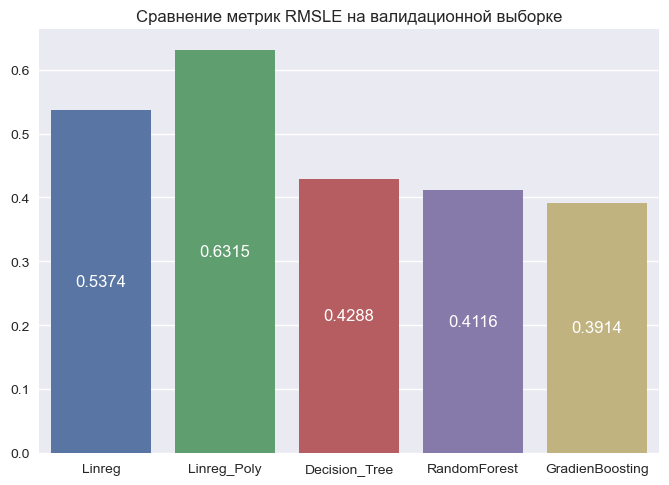

In [42]:
comparison_df = print_metrics(y_test=np.expm1(y_test),
                              y_test_pred=[np.expm1(np.abs(model_4_1.predict(X_test_scaled))),
                                           np.expm1(np.abs(model_for_poly.predict(X_test_poly))),
                                           np.expm1(np.abs(model_tree.predict(X_test_scaled))),
                                           np.expm1(np.abs(model_5_1.predict(X_test_scaled))),
                                           np.expm1(np.abs(model_5_2.predict(X_test_scaled)))],
                              list_of_metrics=['root_mean_squared_log_error'],
                              names=['Linreg', 'Linreg_Poly', 'Decision_Tree', 'RandomForest', 'GradienBoosting'])

cmpplot = sns.barplot(comparison_df)
[cmpplot.bar_label(cmpplot.containers[i], fmt='%.4f', label_type='center', color='white', fontsize=12) for i in range(comparison_df.shape[1])]
cmpplot.set_title('Сравнение метрик RMSLE на валидационной выборке');

[to contents](#contents)

<h3 id='feauturesimportances'>5.4</h3>

Постройте столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажите топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.

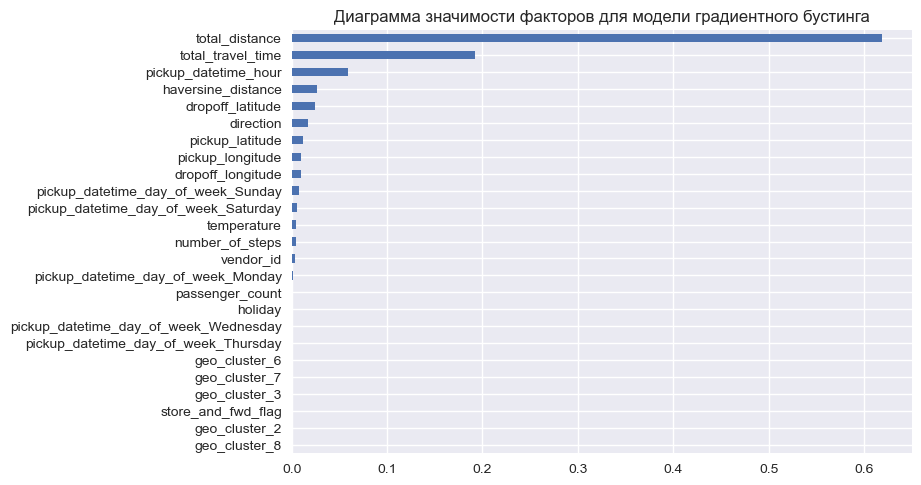

In [43]:
pd.Series(model_5_2.feature_importances_, index=X_train.columns).sort_values().plot(kind='barh')
plt.title('Диаграмма значимости факторов для модели градиентного бустинга');

[to contents](#contents)

<h3 id='meaeforgradientboosting'>5.5</h3>

Для лучшей из построенных моделей рассчитайте медианную абсолютную ошибку (`MeAE` - в `sklearn` функция `median_absolute_error`) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики `MeAE` переведите в минуты и округлите до десятых.

In [44]:
print(f"Значение метрики МеАЕ = {round(np.median(np.abs(np.expm1(y_test) - np.expm1(model_5_2.predict(X_test_scaled)))) / 60, 1)} минут")

Значение метрики МеАЕ = 1.8 минут


<h2 style='text-align:center;'>Финальный шаг. Предсказание на неразмеченных данных</h2>

[to contents](#contents)

<h3 id='testdatapreparation'>Преобразование тестовой таблицы</h3>

Файл с данными из OSRM API для тестовой выборки — <a href='https://drive.google.com/file/d/1wCoS-yOaKFhd1h7gZ84KL9UwpSvtDoIA/view'>здесь.</a>

In [48]:
test_df = pd.read_csv('data/test.csv')
osrm_test = pd.read_csv('data/osrm_data_test.csv')[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]

test_df['pickup_datetime'] = pd.to_datetime(test_df['pickup_datetime'], errors='coerce')

Здесь всё по порядку:

|Номер задания|Ссылка|
|-|-|
|1.4|[извлечение данных из признака `pickup_datetime`](#pickupdatetimepreparation)|
|1.5|[добавление признаков из таблицы `holidays`](#holidaysdf)|
|1.6|[добавление признаков из `OSRM` таблицы](#osrmdf)|
|1.7|[подсчёт расстояния хаверсина и азимута из признаков широты и долготы](#haversineazimuth)|
|1.8|[создание признака кластеризации](#geoclustering)|
|1.9|[добавление признаков из таблицы `weather`](#weatherdf)|
|1.10|[заполнение пропусков](#nanvalsinweather)|
|3.1|[удаление неинформативных признаков](#dataleakandnoninform)|
|3.2|[приведение двух признаков к бинарному виду](#vendorflagencoding)|
|3.3|[`OneHot` кодирование других трёх](#pickupdayofweekgeoclustereventsenco)|
|3.4|[выбор наилучших столбцов](#selectkbestselection)|
|3.5|[нормализация MinMaxScaler-ом](#normalizationofx)|

In [49]:
# 1.4
test_df = add_datetime_features(df=test_df, col='pickup_datetime', dayofweek=True)
# 1.5
test_df = add_holiday_features(test_df, holidays_df, on=['pickup_datetime_day_of_week', 'pickup_datetime_date'])
# 1.6
test_df = test_df.merge(osrm_test, how='left', on='id')
# 1.7 (срез [4:8], потому что в тестовой таблице нет признака dropoff_datetime)
test_df['haversine_distance'] = pd.Series(test_df.iloc[:, 4:8].iloc[:, [1, 0, 3, 2]].apply(lambda row: get_haversine_distance(*row), axis=1))
test_df['direction'] = pd.Series(test_df.iloc[:, 4:8].iloc[:, [1, 0, 3, 2]].apply(lambda row: get_angle_direction(*row), axis=1))
# 1.8
test_df['geo_cluster'] = kmeans_1_8.predict(test_df.iloc[:, 4:8].iloc[:, [1, 0, 3, 2]].to_numpy())
# 1.9
test_df = test_df.merge(weather_df, how='left', on=['pickup_datetime_date', 'pickup_datetime_hour'])
# 1.10
test_df = fill_null_weather_data(test_df)
# 3.1
test_df = test_df.drop(columns=['id', 'pickup_datetime', 'pickup_datetime_date'])
# 3.2
test_df['vendor_id'] -= 1
test_df['store_and_fwd_flag'] = test_df['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
# 3.3
onehot_for_test_matrix = onehot_3_3.fit_transform(test_df[columns_to_encode]).toarray()
test_df = pd.concat([test_df.drop(columns=columns_to_encode), pd.DataFrame(onehot_for_test_matrix, columns=onehot_3_3.get_feature_names_out())], axis=1)
# 3.4
test_df = test_df[best_features_3_4]
# 3.5
test_df_scaled = scaler_3_5.transform(test_df)

# Проверка на вшивость
pd.Series(test_df.columns == X_train.columns).value_counts()

True    25
Name: count, dtype: int64

[to contents](#contents)

<h3 id='predictionvssubmission'>Предсказание и запись в submission</h3>

Возьмём модель [Градиентного Бустинга](#gradientboosting), которая показала себя наилучшим образом.

In [ ]:
submission = pd.read_csv('data/sample_submission.csv')

submission['trip_duration'] = np.expm1(model_5_2.predict(test_df_scaled))
#submission.to_csv('submission_2.csv', index = False)

Выводов нет. Проект классный. Следовал шаблону. Ничего своего не привнёс. Хотелось бы, конечно, залететь в топ, но пока не хватает опыта и знаний.) Да и смысл.. 7 лет соревнованию.)) Ну короче..)

Тем, кто дочитал сие досюда (ну или листанул.. навигация жиесть) - спасибо за просмотр.)

<h2 style='text-align:center;'>Дополнительная часть. Реклама XGBoost.))</h2>

[to contents](#contents)

<h3 id='xgboosttest'>Модель XGBoost</h3>

In [50]:
import xgboost as xgb

In [51]:
dtrain = xgb.DMatrix(X_train_scaled, label=y_train, feature_names=list(best_features_3_4))
dvalid = xgb.DMatrix(X_test_scaled, label=y_test, feature_names=list(best_features_3_4))
dtest = xgb.DMatrix(test_df_scaled, feature_names=list(best_features_3_4))

In [52]:
# Гиперпараметры модели
xgb_params = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 'max_depth': 6,
              'subsample': 0.9, 'lambda': 1, 'nthread': -1, 'booster': 'gbtree', 
              'eval_metric': 'rmse', 'objective': 'reg:squarederror'}

# Тренировочная и валидационная выборки
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Обучаем модель XGBoost
model_xgb = xgb.train(params=xgb_params,
                      dtrain=dtrain,
                      num_boost_round=500, # количество моделей в ансамбле
                      evals=watchlist, # выборки, на которых считается матрица
                      early_stopping_rounds=20, # ранняя остановка
                      maximize=False, # смена поиска максимума на минимум
                      verbose_eval=100) # шаг, через который происходит отображение метрик

[0]	train-rmse:0.73989	valid-rmse:0.74183
[100]	train-rmse:0.39279	valid-rmse:0.39728
[200]	train-rmse:0.38309	valid-rmse:0.39044
[300]	train-rmse:0.37732	valid-rmse:0.38737
[400]	train-rmse:0.37286	valid-rmse:0.38563
[499]	train-rmse:0.36917	valid-rmse:0.38458


In [53]:
print_metrics(y_train=np.expm1(y_train),
              y_train_pred=[np.expm1(np.abs(model_xgb.predict(dtrain)))],
              y_test=np.expm1(y_test),
              y_test_pred=[np.expm1(np.abs(model_xgb.predict(dvalid)))],
              list_of_metrics=['root_mean_squared_log_error', 'mean_absolute_error', 'root_mean_squared_error']).round(2)

,train,test
,0,0
RMSLE,0.37,0.38
MAE,283.94,290.66
RMSE,3094.77,3153.76


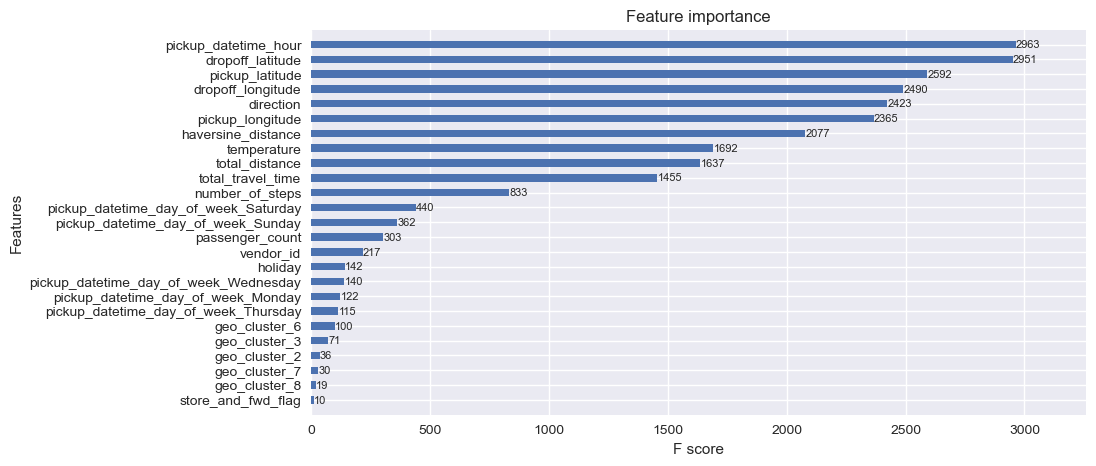

In [54]:
fig, ax = plt.subplots(figsize = (10,5))
xgb.plot_importance(model_xgb, ax=ax, height=0.5, values_format='{v:.0f}')
[text.set_fontsize(8) for text in ax.texts];

[to contents](#contents)